In [1]:
%matplotlib notebook
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import cv2



In [3]:
##########################
### Configurações
##########################

### MODEL_NAME = MODELO + IMAGENS + DETALHES
MODEL_NAME = "ResNet50"

# Hyperparameters
BATCH_SIZE = 8 if torch.cuda.is_available() else 64
NUM_WORKERS = 0 # Zero for Windows

# Architecture
NUM_CLASSES = 7

# Other
DEVICE = "cuda:0" # ou "CPU"

In [4]:
def load_file(path):
    return np.load(path).astype(np.float32)


In [5]:
PATH_DS_PROCESSED_TEST = Path("./IMG224_ALL/PROCESSED-TEST")

pathname = "./WEIGHTS/" + MODEL_NAME + "/"
PATH_DS_WEIGHTS = Path(pathname)

In [6]:
mean = torch.tensor([118.9568,  76.7986,  43.6991]) 
stq = torch.tensor([71.9256, 50.9931, 35.3619]) 

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,stq),
])


test_transforms_sem_norm = transforms.Compose([
    transforms.ToTensor(),  # Convert numpy array to tensor
])




In [7]:
TEST_DATASET = torchvision.datasets.DatasetFolder(
    PATH_DS_PROCESSED_TEST,
    loader=load_file, extensions="npy", transform=test_transforms)

TEST_DATASET_SEM_NORM = torchvision.datasets.DatasetFolder(
    PATH_DS_PROCESSED_TEST,
    loader=load_file, extensions="npy", transform=test_transforms_sem_norm)

In [8]:
class LTResNet50Module(pl.LightningModule):
    def __init__(self):
        super().__init__()
      
        self.model = torchvision.models.resnet50(pretrained=True)
        fc_in_features = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(in_features=fc_in_features, out_features=NUM_CLASSES, bias=True)
        
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])
        
    def forward(self, data): 
        # Compute feature map
        feature_map = self.feature_map(data)
        # Use Adaptive Average Pooling as in the original model
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        # Flatten the output into a 512 element vector
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        # Compute prediction
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map



In [9]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    features = features.reshape((512, 49))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()
    
    
    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)

In [10]:
model = LTResNet50Module.load_from_checkpoint(PATH_DS_WEIGHTS / "epoch=2-step=1914.ckpt", strict=False)
model.eval()


C:\Users\AsusTon\anaconda3\envs\tcc_evn\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\AsusTon\anaconda3\envs\tcc_evn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\AsusTon\anaconda3\envs\tcc_evn\lib\site-packages\pytorch_lightning\core\saving.py:251: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight',

LTResNet50Module(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [11]:
def cam(model, img):
    """
    Compute class activation map according to cam algorithm
    """
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    b, c, h, w = features.shape

    # We reshape the 512x7x7 feature tensor into a 512x49 tensor in order to simplify the multiplication
    features = features.reshape((c, h*w))
    
    # Get only the weights, not the bias
    weight_params = list(model.model.fc.parameters())[0] 
    
    # Remove gradient information from weight parameters to enable numpy conversion
    weight = weight_params[0].detach()

    # Compute multiplication between weight and features with the formula from above.
    # We use matmul because it directly multiplies each filter with the weights
    # and then computes the sum. This yields a vector of 49 (7x7 elements)
    cam = torch.matmul(weight, features)
    
    ### The following loop performs the same operations in a less optimized way
    #cam = torch.zeros((7 * 7))
    #for i in range(len(cam)):
    #    cam[i] = torch.sum(weight*features[:,i])
    ##################################################################
    
    # Normalize and standardize the class activation map (Not always necessary, thus not shown in the lecture)
    #cam = cam - torch.min(cam)
    #cam_img = cam / torch.max(cam)
    # Reshape the class activation map to 512x7x7 and move the tensor back to CPU
    cam_img = cam.reshape(h, w).cpu()

    return cam_img, torch.sigmoid(pred)


In [12]:
def ajustImage(img):
    
    new_img = img.permute(1, 2, 0)
    new_img = new_img.numpy()
    #new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    
    return new_img.astype(np.uint8)


In [14]:
def GetDescription(label):
    classes  = ["Normal","Diabetes","Glaucoma", "Catarata", "Deg. Macular","Hipertensao", "Miopia Pat."]
    int_label = int(label)
    return classes[int_label]
    
def GetNDCAMDescription(label):
    """
        0-N - Normal
        1-D - Diabetes
        2-C - Catarata
        3-A - Degeneração macular
        4-M - Miopia patológica 
    """
    label = str(label)
    if(label=="0"):
        return "Normal"
    
    if(label=="1"):
        return "Diabetes"
    
    if(label=="2"):
        return "Catarata"
    
    if(label=="3"):
        return "Deg. Macular"
    
    if(label=="4"):
        return "Miopia Pat."
    

In [15]:
def visualize(img, cam, pred,label, fila_name):
    
    img = ajustImage(img)
    
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(1, 2)
    axis[0].axis("off")
    axis[1].axis("off")

    
    axis[0].imshow(img)
    
    axis[1].imshow(img)
    axis[1].imshow(cam, alpha=0.50, cmap="jet")
    
    pred_r = pred.argmax(dim=-1)
    plt.title(f"label ={label} pred = {pred_r} - {fila_name}")

In [16]:
def show(inds):
    for i in inds:
        img_number = i
        img = TEST_DATASET[img_number][0]  # Select a subject
        img_sem_norm = TEST_DATASET_SEM_NORM[img_number][0]
        label = TEST_DATASET[img_number][1]
        fila_name = TEST_DATASET.samples[img_number][0].split("\\")[3]

        activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject
        
        visualize(img_sem_norm, activation_map, pred, label, fila_name)
        

In [17]:
def visualize2(images, cams, pred, label, fila_name):
    lenght = len(images)
    
    for i in range(lenght):
        images[i] = ajustImage(images[i])
        cams[i] = transforms.functional.resize(cams[i].unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(lenght, 2, figsize=(10, 20.5))
    for i in range(lenght):
        #axis[i,0].axis("off")
        #axis[i,1].axis("off")
        
        axis[i,0].tick_params(axis='both', bottom= False, top= False, left=False, right= False, 
                              labelbottom = False, labeltop=False, labelleft=False, labelright=False)
        axis[i,1].tick_params(axis='both', bottom= False, top= False, left=False, right= False, 
                              labelbottom = False, labeltop=False, labelleft=False, labelright=False)
        
        axis[i,0].imshow(images[i])
        axis[i,1].imshow(images[i])
        axis[i,1].imshow(cams[i], alpha=0.50, cmap="jet")
    
        pred_r = pred[i].argmax(dim=-1)
        
        axis[i,0].xaxis.set_label_position('top')
        axis[i,1].xaxis.set_label_position('top')
        
        axis[i,0].set_xlabel(f"Real: {GetNDCAMDescription(label[i])}")
        axis[i,1].set_xlabel(f"Previsto: {GetNDCAMDescription(pred_r.numpy())}")


In [18]:
def visualize3(images, cams, pred, label, fila_name):
    lenght = len(images)
    
    for i in range(lenght):
        images[i] = ajustImage(images[i])
        cams[i] = transforms.functional.resize(cams[i].unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(1, 4, figsize=(10, 10))
        
    axis[0].tick_params(axis='both', bottom= False, top= False, left=False, right= False, 
                          labelbottom = False, labeltop=False, labelleft=False, labelright=False)
    axis[1].tick_params(axis='both', bottom= False, top= False, left=False, right= False, 
                          labelbottom = False, labeltop=False, labelleft=False, labelright=False)
    axis[2].tick_params(axis='both', bottom= False, top= False, left=False, right= False, 
                          labelbottom = False, labeltop=False, labelleft=False, labelright=False)
    axis[3].tick_params(axis='both', bottom= False, top= False, left=False, right= False, 
                          labelbottom = False, labeltop=False, labelleft=False, labelright=False)
    axis[0].xaxis.set_label_position('top')
    axis[1].xaxis.set_label_position('top')
    axis[2].xaxis.set_label_position('top')
    axis[3].xaxis.set_label_position('top')
    
    
    axis[0].imshow(images[0])
    axis[1].imshow(images[0])
    axis[1].imshow(cams[0], alpha=0.50, cmap="jet")

    pred_r = pred[0].argmax(dim=-1)
    
    axis[0].set_xlabel(f"Real: {GetNDCAMDescription(label[0])}")
    axis[1].set_xlabel(f"Previsto: {GetNDCAMDescription(pred_r.numpy())}")
    
    
    
    axis[2].imshow(images[1])
    axis[3].imshow(images[1])
    axis[3].imshow(cams[1], alpha=0.50, cmap="jet")

    pred_r = pred[1].argmax(dim=-1)
    
    axis[2].set_xlabel(f"Real: {GetNDCAMDescription(label[1])}")
    axis[3].set_xlabel(f"Previsto: {GetNDCAMDescription(pred_r.numpy())}")

    

In [19]:
def show2(inds):
    img_sem_norm = []
    activation_map = []
    file_name = []
    preds = []
    labels = []
    for i in inds:
        img = TEST_DATASET[i][0]  # Select a subject
        
        img_sem_norm.append(TEST_DATASET_SEM_NORM[i][0])
        labels.append(TEST_DATASET[i][1])
        file_name.append(TEST_DATASET.samples[i][0].split("\\")[3])

        activation_map_aux, pred_aux = cam(model, img)  # Compute the Class activation map given the subject
        activation_map.append(activation_map_aux)
        preds.append(pred_aux)
    
    visualize2(img_sem_norm, activation_map, preds, labels, file_name)
        

In [20]:
def show3(inds):
    img_sem_norm = []
    activation_map = []
    file_name = []
    preds = []
    labels = []
    for i in inds:
        img = TEST_DATASET[i][0]  # Select a subject
        
        img_sem_norm.append(TEST_DATASET_SEM_NORM[i][0])
        labels.append(TEST_DATASET[i][1])
        file_name.append(TEST_DATASET.samples[i][0].split("\\")[3])

        activation_map_aux, pred_aux = cam(model, img)  # Compute the Class activation map given the subject
        activation_map.append(activation_map_aux)
        preds.append(pred_aux)
    
    visualize3(img_sem_norm, activation_map, preds, labels, file_name)

<IPython.core.display.Javascript object>


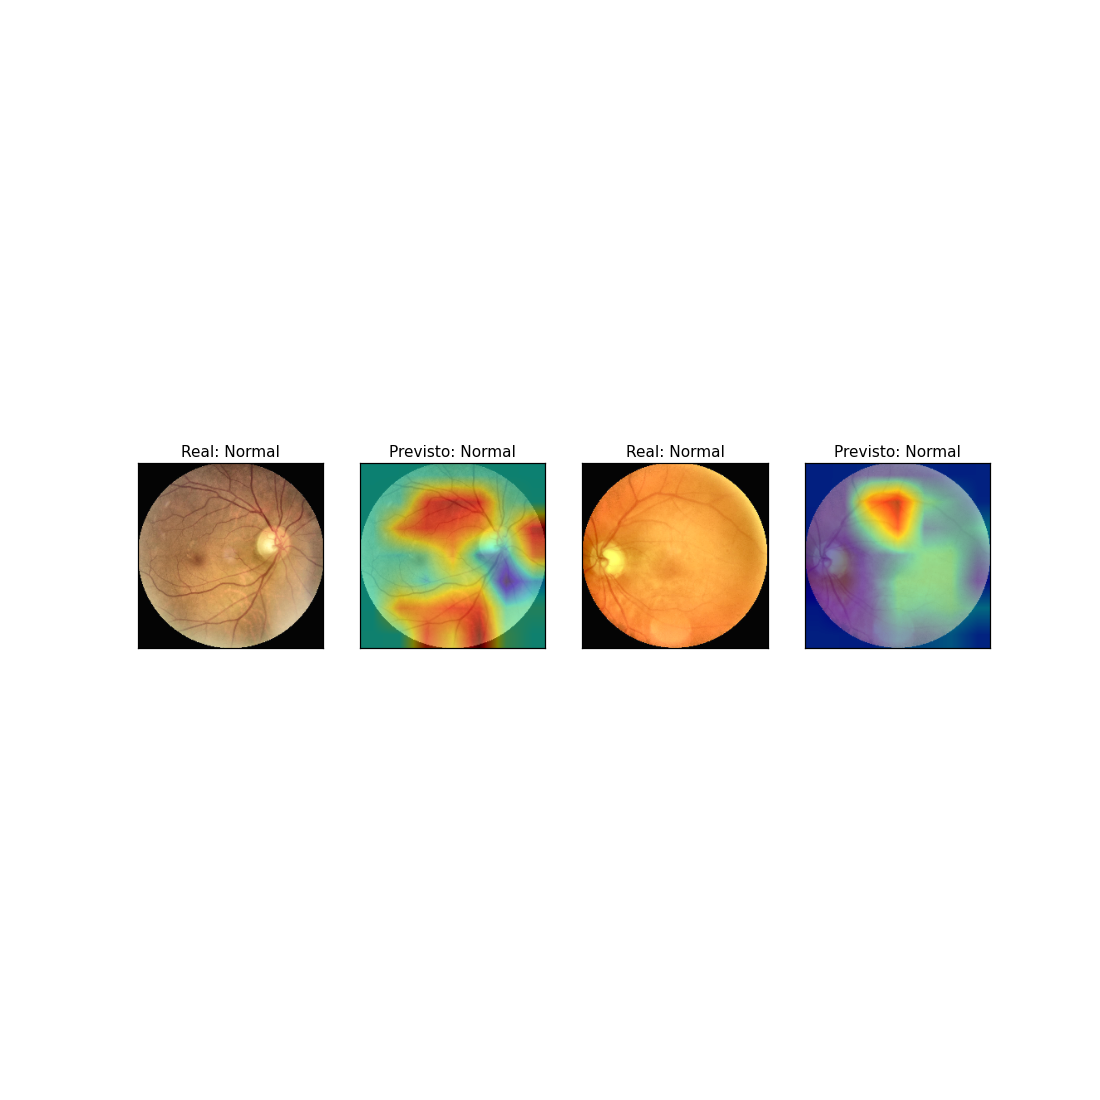

In [21]:
#visualize(img, activation_map, pred, label, fila_name)  # Visualize CAM
#diabetes de 386 até 661
#show2([390, 411, 419, 431, 661])

show3([391, 420])

<IPython.core.display.Javascript object>


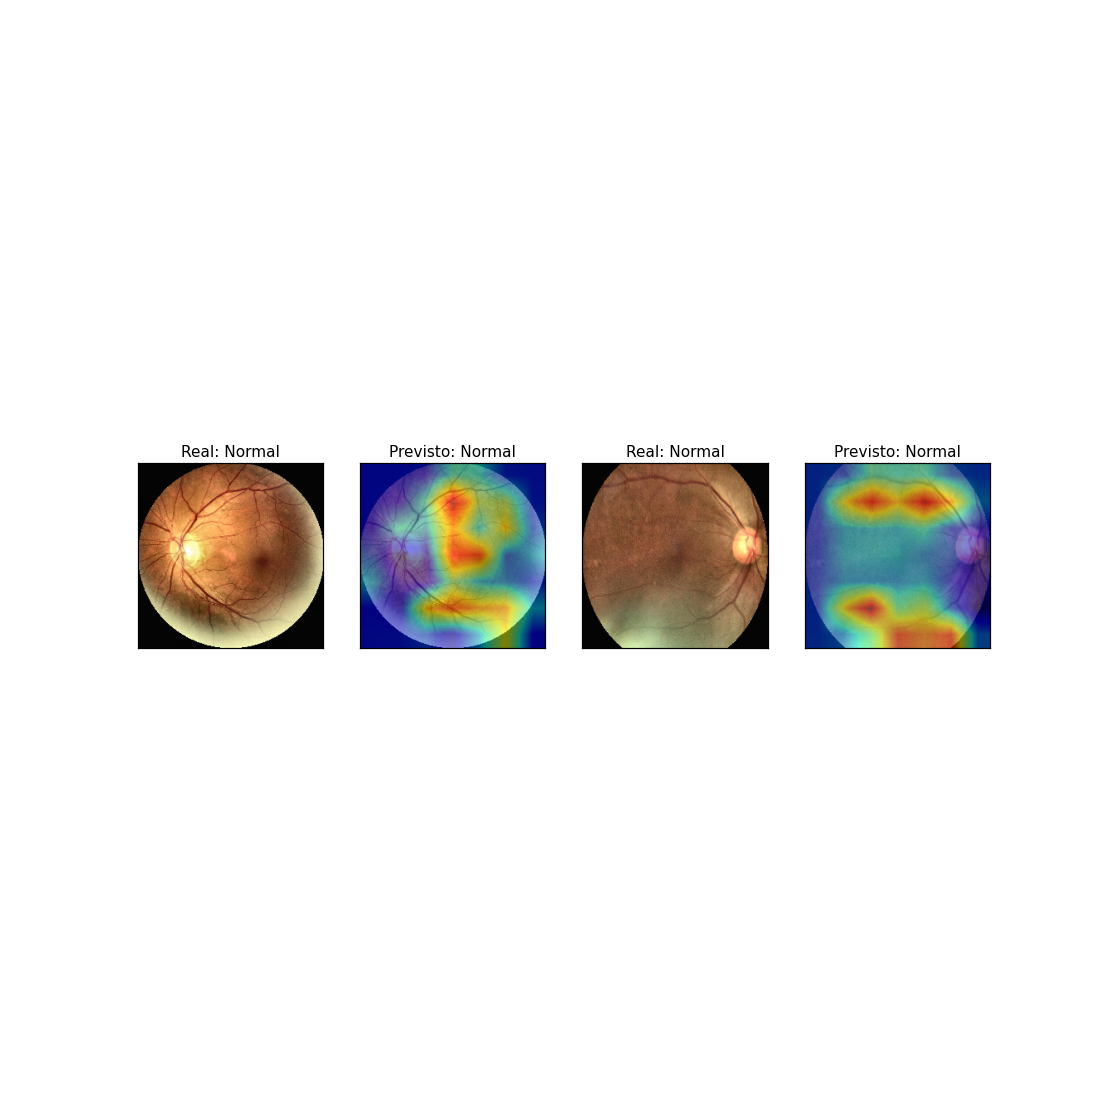

In [22]:
#visualize(img, activation_map, pred, label, fila_name)  # Visualize CAM
#diabetes de 662 até 742
#show2([675, 698, 729, 736])

show3([681, 698])


<IPython.core.display.Javascript object>


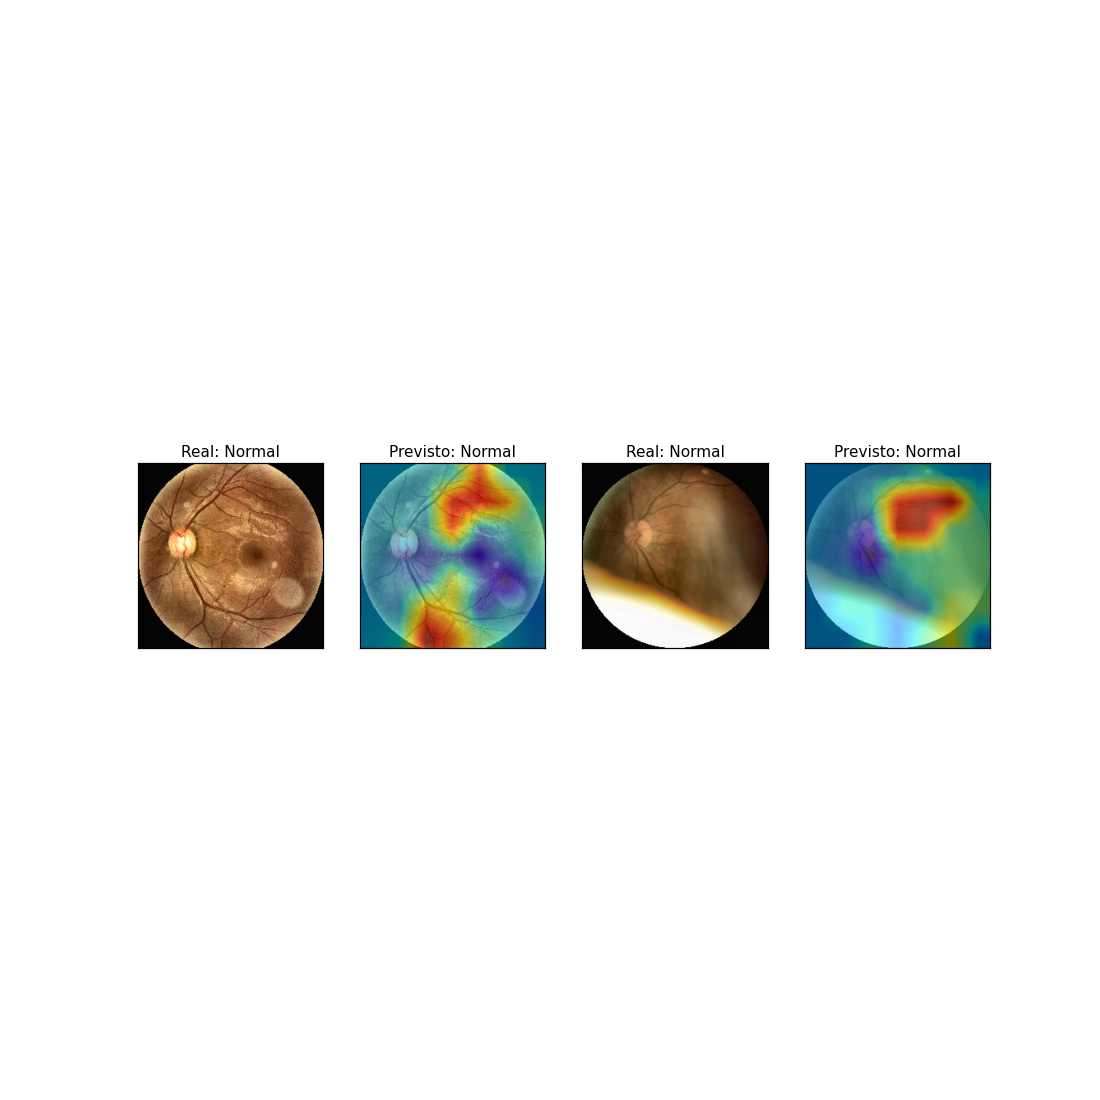

In [23]:
#visualize(img, activation_map, pred, label, fila_name)  # Visualize CAM
#diabetes de 743 até 812
#show2([743, 761, 799, 812])
show3([743, 761])

<IPython.core.display.Javascript object>


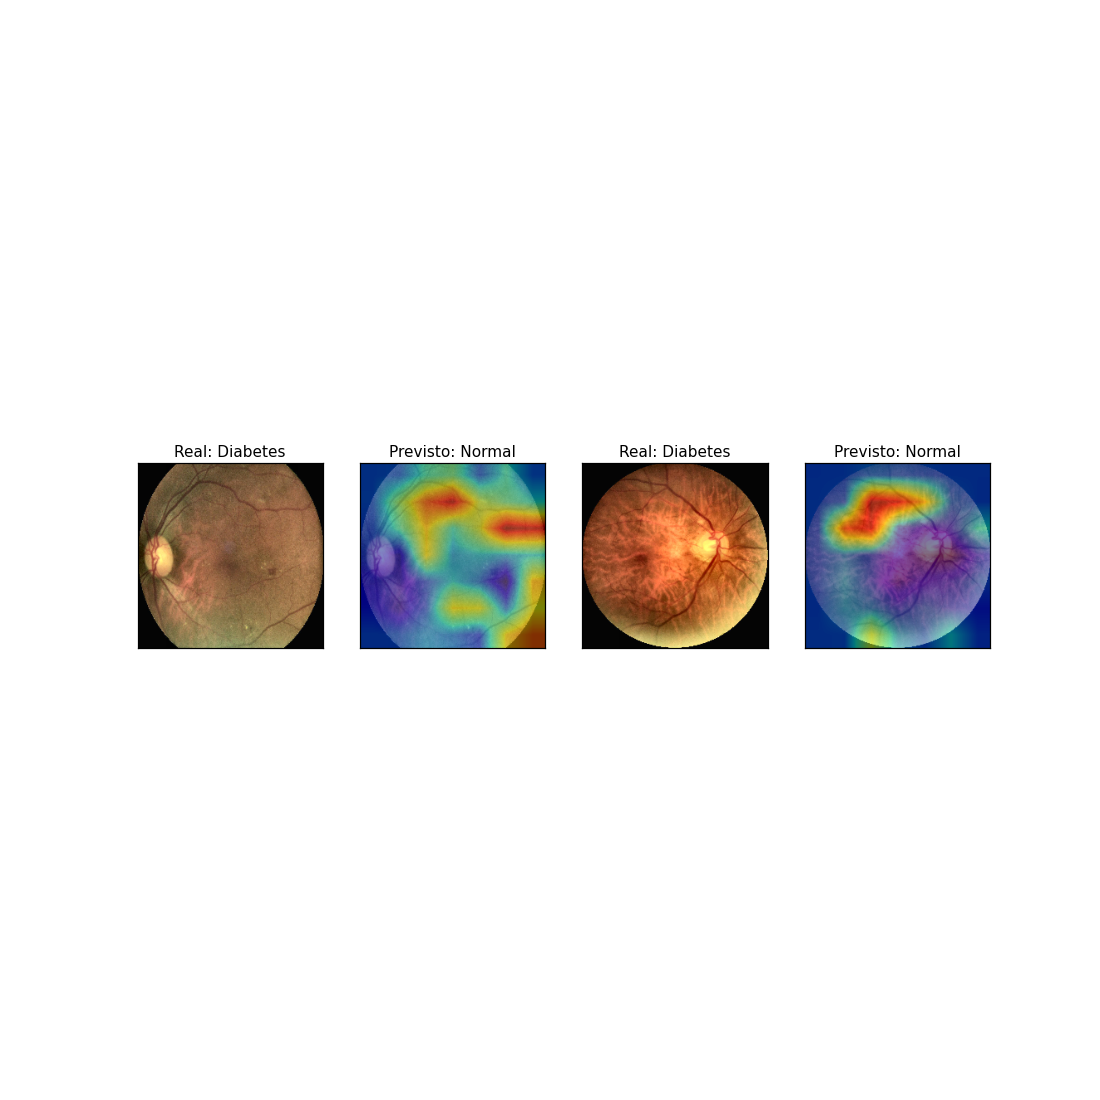

In [24]:
#visualize(img, activation_map, pred, label, fila_name)  # Visualize CAM
#show2([819, 826, 828, 843])
show3([819, 843])